# VAE on Rydberg

In [1]:
from IPython.display import clear_output
clear_output(wait=True)

### Importation

In [ ]:
import netket as nk
import jax
from netket.operator.spin import sigmax,sigmaz
from jax import numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Experimental data 12x12

### Dataset convertion

In [ ]:
import numpy as np

all_Rb = jnp.array([1.01,1.05,1.13,1.23,1.30,1.39,1.46,1.56,1.65,1.71,1.81,1.89,1.97])
all_Rb_str = ['1.01','1.05','1.13','1.23','1.30','1.39','1.46','1.56','1.65','1.71','1.81','1.89','1.97']
detunings = np.load('detunings.npz')
delta = detunings['detunings']
delta

array([-2.3255814 , -2.09302326, -1.86046512, -1.62790698, -1.39534884,
       -1.1627907 , -0.93023256, -0.69767442, -0.46511628, -0.23255814,
        0.        ,  0.23255814,  0.46511628,  0.69767442,  0.93023256,
        1.1627907 ,  1.39534884,  1.62790698,  1.86046512,  2.09302326,
        2.3255814 ,  2.55813953,  2.79069767,  3.02325581,  3.25581395,
        3.48837209,  3.72093023,  3.95348837,  4.18604651,  4.41860465,
        4.65116279])

In [ ]:
L = 13
N = L*L
num_samples_per_param = 250
dataset = jnp.zeros((jnp.size(all_Rb),jnp.size(delta),num_samples_per_param,N))

snake_idx = jnp.zeros((N,2))
for i in range(N):
  #position of each atoms using the snake numbering
  y = i//L
  x = (y%2==0)*(i%L) + (y%2==1)*(L-1-i%L)
  snake_idx = snake_idx.at[i].set(jnp.array([y, x]))

snake_idx = snake_idx.astype(jnp.int64)
snake_idx = [i * L + j for i, j in snake_idx]

for i,Rb in enumerate(all_Rb_str):
  data = np.load('detuning_sweep_Rb_{}.npz'.format(Rb))
  reshaped_data = data['rydberg_populations_per_param'].transpose(2, 3, 0, 1).reshape(jnp.size(delta),num_samples_per_param,N)[:,:,snake_idx]
  dataset = dataset.at[i].set(reshaped_data)

In [ ]:
dataset.shape

(13, 31, 250, 169)

In [ ]:
data = {'dataset': dataset, 'all_Rb': all_Rb, 'all_delta': delta}

In [ ]:
with open('data_RydbergExpL13.pkl', 'wb') as f:
    pickle.dump(data, f)

### Dataset loading

In [ ]:
with open('data_RydbergExpL13.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
dataset = data['dataset']*2-1
all_Rb = data['all_Rb']
all_delta = data['all_delta']
L = 13
N = L*L

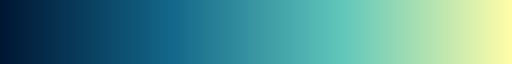

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

custom_palette = ['#001733', '#13678A', '#60C7BB', '#FFFDA8']
#cmap = ListedColormap(custom_palette)
cmap_blue = LinearSegmentedColormap.from_list("custom_cmap", custom_palette)
cmap_blue

In [ ]:
def fourier_transf(k1,k2,x):
  F = 0
  for i in range(N):
    xi = (i%L) + (i//L)*L
    yi = i//L
    F += jnp.exp(-1j*(k1*xi+k2*yi))*x[...,i]
  return F/jnp.sqrt(N)

def sym_fourier_transf(k1,k2,x):
  return 0.5*(fourier_transf(k1,k2,x) + fourier_transf(k2,k1,x))

def is_check_phase(x):
  return sym_fourier_transf(jnp.pi,jnp.pi,x) -sym_fourier_transf(jnp.pi,0,x)

is_check_phase_vmap = jax.vmap(jax.vmap(jax.vmap(is_check_phase)))

def is_star_phase(x):
  return sym_fourier_transf(jnp.pi,jnp.pi/2,x)

is_star_phase_vmap = jax.vmap(jax.vmap(jax.vmap(is_star_phase)))

def is_striated_phase(x):
  return sym_fourier_transf(jnp.pi,0,x) - sym_fourier_transf(jnp.pi,jnp.pi/2,x)

is_striated_phase_vmap = jax.vmap(jax.vmap(jax.vmap(is_striated_phase)))

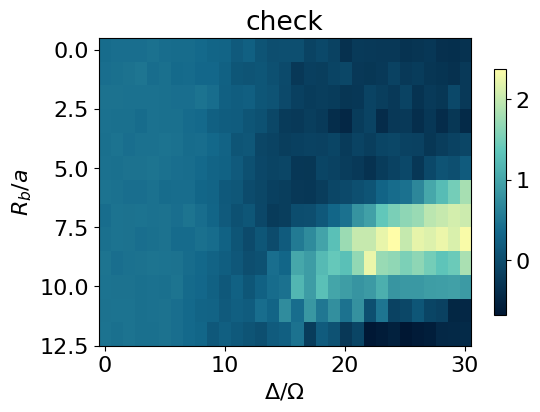

In [ ]:
check = -jnp.mean(is_check_phase_vmap(dataset), axis=-1).real #< -0.5


plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,4),dpi=100)


plt.imshow(jnp.flipud(check), cmap=cmap_blue, aspect='auto')
plt.xlabel(r'$\Delta/\Omega$')
plt.ylabel(r'$R_b/a$')


cbar = plt.colorbar(shrink=0.8)
plt.title(r'check')
plt.show()

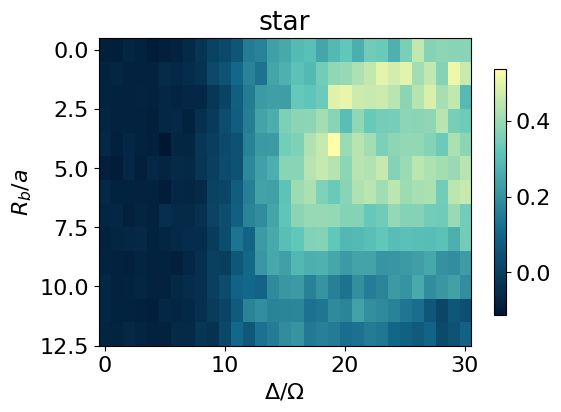

In [ ]:
star = jnp.mean(is_star_phase_vmap(dataset), axis=-1).real #< -0.5


plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,4),dpi=100)


plt.imshow(jnp.flipud(star), cmap=cmap_blue, aspect='auto')
plt.xlabel(r'$\Delta/\Omega$')
plt.ylabel(r'$R_b/a$')


cbar = plt.colorbar(shrink=0.8)
plt.title(r'star')
plt.show()

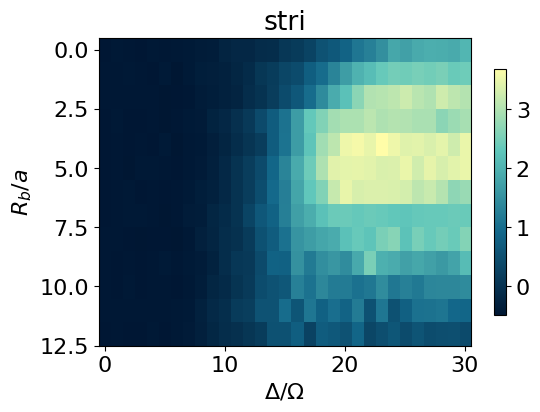

In [ ]:
stri = jnp.mean(is_striated_phase_vmap(dataset), axis=-1).real#< -0.5


plt.rcParams['font.size'] = 16
plt.figure(figsize=(6,4),dpi=100)


plt.imshow(jnp.flipud(stri), cmap=cmap_blue, aspect='auto')
plt.xlabel(r'$\Delta/\Omega$')
plt.ylabel(r'$R_b/a$')

cbar = plt.colorbar(shrink=0.8)
plt.title(r'stri')
plt.show()

### Transformer

#### Code

In [ ]:
import optax
from flax import linen as nn
from functools import partial
from netket import jax as nkjax

class PositionalEncoding(nn.Module):
    d_model: int
    dropout: float
    max_len: int = N

    def setup(self):
        pe = jnp.zeros((self.max_len, self.d_model))
        position = jnp.arange(0, self.max_len)[:, None]
        div_term = jnp.exp(
            jnp.arange(0, self.d_model, 2) * -(jnp.log(10000.0) / self.d_model)
        )
        pe = pe.at[:, 0::2].set(jnp.sin(position * div_term))
        pe = pe.at[:, 1::2].set(jnp.cos(position * div_term))
        self.pe = pe[None, :, :]

    @nn.compact
    def __call__(self, x, train):
        """Add positional encoding and apply dropout (not used in fact)"""
        x = x + self.pe[:, : x.shape[1], :]
        return nn.Dropout(self.dropout, deterministic=not train)(x)


def shift_right(x, start_token):
    # x shape: [batch_size, seq_length, d_model]
    batch_size = x.shape[0]
    start_tokens = jnp.broadcast_to(start_token, (batch_size, 1, x.shape[-1]))
    return jnp.concatenate([start_tokens, x[:, :-1, :]], axis=1)



class Transformer_encoder(nn.Module):
    dropout: float
    num_heads: int
    d_model: int
    d_ff: int
    num_layers: int
    latent_dim: int

    @nn.compact
    def __call__(self, inputs, train=True):

        x = inputs
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)

        # Embedding of atom config.
        x = (x + 1)//2
        x = nn.Embed(2, self.d_model)(x.astype(jnp.int64))

        x = PositionalEncoding(self.d_model, self.dropout, max_len=N+1)(x, train=train)


        ## Encoder transf. layers
        for i in range(self.num_layers):
            # Self-attention
            x = x + nn.MultiHeadDotProductAttention(num_heads=self.num_heads, dropout_rate=self.dropout, deterministic=not train)(nn.LayerNorm()(x), nn.LayerNorm()(x), nn.LayerNorm()(x))
            # Feed forward
            x = x + nn.Sequential([
                nn.Dense(4 * self.d_model),
                nn.relu,
                nn.Dense(self.d_model),
                nn.Dropout(rate=self.dropout, deterministic=not train)
            ])(nn.LayerNorm()(x))

            x = nn.LayerNorm()(x)

        # Projection on the latent space (prediction of mu and logvar)
        mean = nn.Dense(self.latent_dim)(x.reshape(batch_size,-1))
        logvar = nn.Dense(self.latent_dim)(x.reshape(batch_size,-1))

        return mean, logvar




class Transformer_decoder(nn.Module):
    dropout: float
    num_heads: int
    d_model: int
    d_ff: int
    num_layers: int

    @nn.compact
    def __call__(self, inputs, train=True):

        z, x = inputs
        batch_size = z.shape[0]

        # Embedding of atom config.
        x = (x + 1)//2
        x = nn.Embed(2, self.d_model)(x.astype(jnp.int64))

        x = PositionalEncoding(self.d_model, self.dropout)(x, train=train)
        #need to shift the sequence s.t. the model doesnt see atom xi to predict p(xi|xj,j<i)
        start_token = self.param("start_token", nn.initializers.normal(), (1, self.d_model))
        x = shift_right(x, start_token)


        #mask used to impose the autoregressivity
        seq_length = x.shape[1]
        causal_mask = jnp.tril(jnp.ones((seq_length, seq_length), dtype=bool), k=0)
        # Expand dimensions to broadcast across batch and heads.
        causal_mask = causal_mask[None, None, :, :]

        #the memory used for context based attention is the latent variables
        memory = z
        memory = nn.Dense(self.d_model)(memory) #lin. layer to expend the dim. to d_model
        memory = jnp.tile(memory[:, None, :], (1, seq_length, 1)) # Tile to seq_length

        ## Decoder transf. layers
        for i in range(self.num_layers):
            # Self-attention with causal mask
            x = x + nn.MultiHeadDotProductAttention(num_heads=self.num_heads, dropout_rate=self.dropout, deterministic=not train)(nn.LayerNorm()(x), nn.LayerNorm()(x), mask=causal_mask)

            # Context based attention with context given by the latent var.
            x = x + nn.MultiHeadDotProductAttention(num_heads=self.num_heads, dropout_rate=self.dropout, deterministic=not train)(nn.LayerNorm()(x), memory)
            # Feed forward
            x = x + nn.Sequential([
                nn.Dense(4 * self.d_model),
                nn.relu,
                nn.Dense(self.d_model),
                nn.Dropout(rate=self.dropout, deterministic=not train)
            ])(nn.LayerNorm()(x))

            x = nn.LayerNorm()(x)

        # Projection
        x = nn.Dense(2, kernel_init=nn.initializers.truncated_normal(stddev=0.02), bias_init=nn.initializers.zeros)(x)
        x = nn.log_softmax(x + 1e-10, axis=-1)

        return x



class transformer_VAE(nn.Module):
    """Complete VAE architecture including the encoder, the decoder and the reparametrization trick in the latent space"""
    dropout: float
    num_heads: int
    d_model: int
    d_ff: int
    num_layers: int
    latent_dim: int

    def setup(self):
        self.encoder = Transformer_encoder(dropout = self.dropout,
                                           num_heads = self.num_heads,
                                           d_model = self.d_model,
                                           d_ff = self.d_ff,
                                           num_layers = self.num_layers,
                                           latent_dim = self.latent_dim)

        self.decoder = Transformer_decoder(dropout = self.dropout,
                                           num_heads = self.num_heads,
                                           d_model = self.d_model,
                                           d_ff = self.d_ff,
                                           num_layers = self.num_layers)



    def reparameterize(self, mean, logvar, key):
        # Reparameterization trick
        std = jnp.exp(0.5 * logvar)
        eps = jax.random.normal(key, mean.shape)
        return mean + eps * std

    def __call__(self, x, key, train):

        mean, logvar = self.encoder(x, train=False)
        key = jax.random.split(key)[0]
        z = self.reparameterize(mean, logvar, key)
        inputs = (z, x)
        p = self.decoder(inputs, train=train)

        return mean, logvar, z, p







def log_normal_pdf(mu, logvar, sample):
    return -0.5 * ((sample - mu) ** 2 * jnp.exp(-logvar) + logvar + jnp.log(2. * jnp.pi))


def log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian."""
    normalization = -0.5 * (jnp.log(2 * jnp.pi) + logvar)
    inv_var = jnp.exp(-logvar)
    log_density = normalization - 0.5 * ((x - mu) ** 2 * inv_var)
    return log_density



#code inspired from the following pytorch implementation https://github.com/YannDubs/disentangling-vae/tree/master

def matrix_log_density_gaussian(x, mu, logvar):
    """Calculates log density of a Gaussian for all batch pairs."""
    batch_size, dim = x.shape
    x = x[:, None, :]
    mu = mu[None, :, :]
    logvar = logvar[None, :, :]
    return log_density_gaussian(x, mu, logvar)

def log_importance_weight_matrix(batch_size, dataset_size):
    """Calculates a log importance weight matrix."""
    N = dataset_size
    M = batch_size - 1
    strat_weight = (N - M) / (N * M)
    W = jnp.full((batch_size, batch_size), 1 / M)
    W = W.at[jnp.diag_indices(batch_size)].set(1 / N)
    W = W.at[jnp.arange(1, batch_size), jnp.arange(batch_size - 1)].set(strat_weight)
    W = W.at[M - 1, 0].set(strat_weight)
    return jnp.log(W)

def _get_log_pz_qz_prodzi_qzCx(latent_sample, latent_dist, n_data, is_mss=True):
    batch_size, hidden_dim = latent_sample.shape

    # calculate log q(z|x)
    log_q_zCx = log_density_gaussian(latent_sample, *latent_dist).sum(axis=1)

    # calculate log p(z) (standard normal prior)
    zeros = jnp.zeros_like(latent_sample)
    log_pz = log_density_gaussian(latent_sample, zeros, zeros).sum(axis=1)

    mat_log_qz = matrix_log_density_gaussian(latent_sample, *latent_dist)

    if is_mss:
        # use stratification
        log_iw_mat = log_importance_weight_matrix(batch_size, n_data)
        mat_log_qz = mat_log_qz + log_iw_mat[:, :, None]

    log_qz = jax.scipy.special.logsumexp(mat_log_qz.sum(axis=2), axis=1)
    log_prod_qzi = jax.scipy.special.logsumexp(mat_log_qz, axis=1).sum(axis=1)

    return log_pz, log_qz, log_prod_qzi, log_q_zCx






# Loss function
def compute_loss(params, batch, alpha, beta, gamma, key):
    """Compute the VAE loss."""

    key = jax.random.split(key)[0]
    mean, logvar, z, log_p_i  = VAE.apply(params, batch, key, train=False)#, rngs={'dropout': key}) #if using dropout, not used at the end
    key = jax.random.split(key)[0]


    # Reconstruction loss
    x = batch.reshape(-1,N)
    log_p = (1-x)/2*log_p_i[:,:,0] + (1+x)/2*log_p_i[:,:,1]
    recon_loss = -jnp.sum(log_p)/jnp.shape(x)[0]  #double sum over samples in batch and spatial dimension


    #KL loss
    log_pz, log_qz, log_prod_qzi, log_q_zCx  = _get_log_pz_qz_prodzi_qzCx(latent_sample=z, latent_dist=(mean,logvar), n_data=jnp.shape(z)[0], is_mss=True)

    mi_loss = (log_q_zCx - log_qz).mean()
    tc_loss = (log_qz - log_prod_qzi).mean()
    dw_kl_loss = (log_prod_qzi - log_pz).mean()


    loss = recon_loss + alpha*mi_loss + beta*tc_loss + gamma*dw_kl_loss

    return loss


val_grad_fn = jax.jit(jax.value_and_grad(compute_loss))





@jax.jit
def RC_loss(params, batch, key):

    key = jax.random.split(key)[0]
    mean, logvar, z, log_p_i  = VAE.apply(params, batch, key, train=False)

    # Reconstruction loss
    x = batch.reshape(-1,N)
    log_p = (1-x)/2*log_p_i[:,:,0] + (1+x)/2*log_p_i[:,:,1]
    recon_loss = -jnp.sum(log_p)/jnp.shape(x)[0]  #double sum over samples in batch and spatial dimension

    return recon_loss/jnp.shape(x)[0]


@jax.jit
def KL_loss(params, batch, key):


    key = jax.random.split(key)[0]
    mean, logvar, z, p  = VAE.apply(params, batch, key, train=False)

    kl = -0.5*jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
    C = 0
    kl_loss = beta * jnp.abs(kl-C)
    loss = kl_loss
    x = batch
    return loss/jnp.shape(x)[0]



### TRAIN SET ###

def batch_data(dataset, batch_size):
  num_samples = dataset.shape[0]
  num_batches = num_samples // batch_size
  batches = []
  for i in range(num_batches):
    batch = dataset[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return batches

def batch_data_suffled(dataset, batch_size, key):
  """From the training set, creat batches with spin config coming from GS of H with various params."""
  num_samples = dataset.shape[0]
  # Create a permutation of indices
  permutation = jax.random.permutation(key, jnp.arange(num_samples))
  # Shuffle the dataset
  shuffled_dataset = dataset[permutation]
  # Create batches from the shuffled dataset
  num_batches = num_samples // batch_size
  batches = []
  for i in range(num_batches):
    batch = shuffled_dataset[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return batches



def lin_annealing(step, total_steps, max, min):
  """linear schedule used for the gamma hyperparams in the TC loss"""
  beta = max - (step / total_steps) * (max - min)
  return beta


batches = batch_data_suffled(dataset.reshape(-1,N), batch_size=3000, key=jax.random.PRNGKey(123567))
batches = jax.device_put(batches)
input_init = batches[0]




In [ ]:
def plot_latents(params):

  all_mean = jnp.zeros((len(all_Rb),len(all_delta),latent_dim))
  all_mean_abs = jnp.zeros((len(all_Rb),len(all_delta),latent_dim))
  all_logvar = jnp.zeros((len(all_Rb),len(all_delta),latent_dim))
  all_all_mean = jnp.zeros((len(all_Rb),len(all_delta),jnp.shape(dataset)[2],latent_dim))

  get_latent_var = jax.jit(partial(VAE.apply, train=False))

  #params_encoder, params_decoder = params
  #params = data['params']

  for i, Rb in enumerate(all_Rb):
      for j, delta in enumerate(all_delta):

          #print('h1: {}, h2: {}'.format(h1,h2))
          d = dataset[i,j]#[batch_size*b:batch_size*(b+1),:]
          #means, logvar, z  = get_latent_var({'params': params_encoder}, d, key)
          means, logvar, z, _  = get_latent_var(params, d, key)#, train=False)

          all_mean = all_mean.at[i,j].set(jnp.mean(means,axis=0))
          #all_mean_abs = all_mean_abs.at[i,j].set(jnp.mean(jnp.abs(means),axis=0))
          all_all_mean = all_all_mean.at[i,j].set(means)
          all_logvar = all_logvar.at[i,j].set(jnp.mean(logvar,axis=0))


  idx = jnp.argsort(jnp.mean(all_logvar, axis=(0,1)))

  for i in range(5):

      plt.imshow(jnp.flipud(jnp.mean(all_all_mean[:,:,:,idx[i]],axis=-1)), aspect='auto')
      plt.colorbar()
      plt.title(r'$\mu_{}$'.format(i))
      plt.xlabel(r'$\Delta/\Omega$')
      plt.ylabel(r'$R_b/a$')

      x_tick_positions = [0, 19, 39]
      x_tick_labels = ['-2', '1', '4']
      #plt.xticks(x_tick_positions, x_tick_labels)

      y_tick_positions = [0,19,39]
      y_tick_labels = ['2.0', '1.5', '1.0']
      #plt.yticks(y_tick_positions, y_tick_labels)

      plt.show()

      plt.imshow(jnp.flipud(all_logvar[:,:,idx[1]]), aspect='auto')
      plt.colorbar()
      plt.title(r'$\log\sigma_{}$'.format(i))
      plt.xlabel(r'$\Delta/\Omega$')
      plt.ylabel(r'$R_b/a$')

      x_tick_positions = [0, 19, 39]
      x_tick_labels = ['-2', '1', '4']
      #plt.xticks(x_tick_positions, x_tick_labels)

      y_tick_positions = [0,19,39]
      y_tick_labels = ['2.0', '1.5', '1.0']
      #plt.yticks(y_tick_positions, y_tick_labels)



      plt.show()




#### Training

alpha: 0.001,  beta: 10,  gamma_max: 1.0, gamma_min: 1.0
step: 0, loss: -196.7094459889522, KL: 0.0, RC: 0.038306947778958635
logvar: [ 0.33890846  0.17059396  0.13386368 -1.63408567  0.32045992]
step: 2, loss: -247.4093760392964, KL: 0.0, RC: 0.02383673584009148
logvar: [-2.45030766 -0.18270438 -0.02070352 -2.34814103 -0.3771077 ]
step: 4, loss: -257.98282688238504, KL: 0.0, RC: 0.020538763449971086
logvar: [-2.65545504 -0.16157789 -0.08876864 -3.13775129 -0.19187387]
step: 6, loss: -260.1685725366299, KL: 0.0, RC: 0.0198201964193542
logvar: [-2.84692723 -0.06331381 -0.04310714 -3.68849436 -0.23835764]
step: 8, loss: -261.93057103511177, KL: 0.0, RC: 0.019161816283135895
logvar: [-2.88645287 -0.07258772 -0.14258355 -3.60987346 -0.05454985]
step: 10, loss: -263.1863268381365, KL: 0.0, RC: 0.018794977920041374
logvar: [-3.01084806 -0.1731489  -0.0347402  -3.69030904 -0.16519137]
step: 12, loss: -263.8785823796217, KL: 0.0, RC: 0.01859766455812868
logvar: [-2.62336376  0.00850119 -0.0571

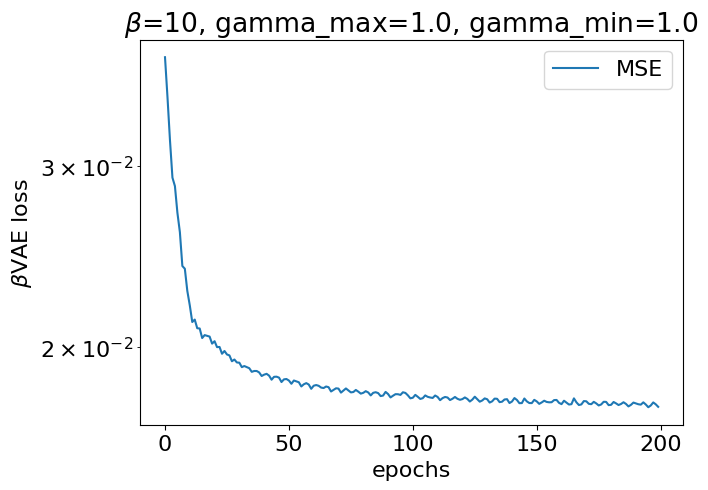

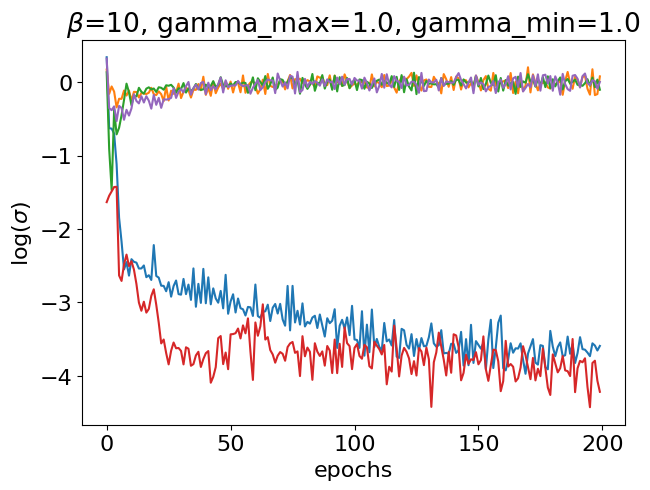

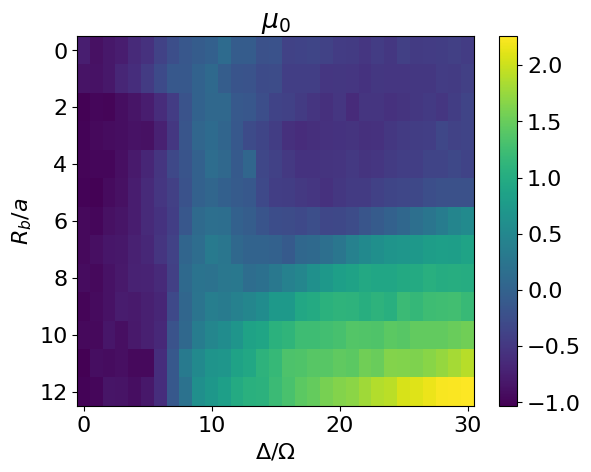

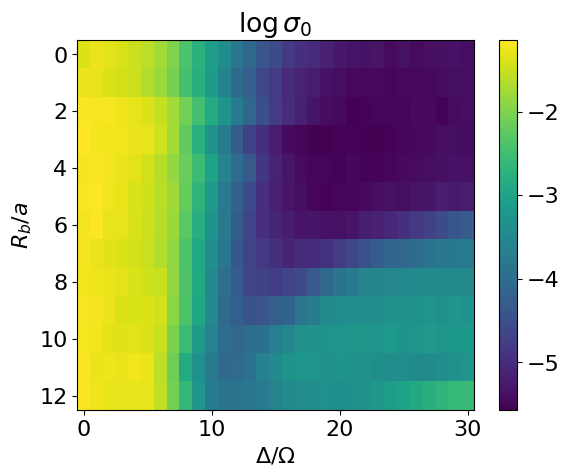

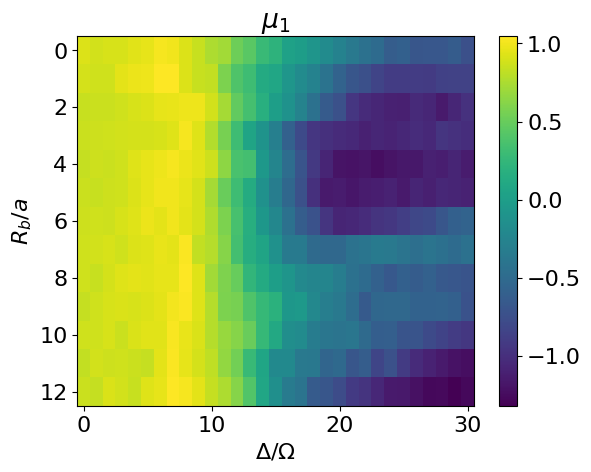

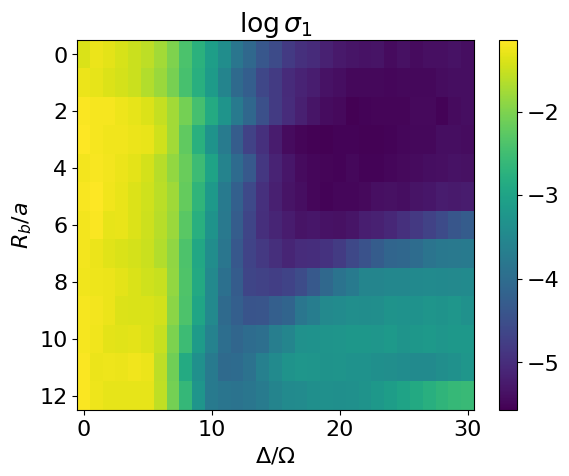

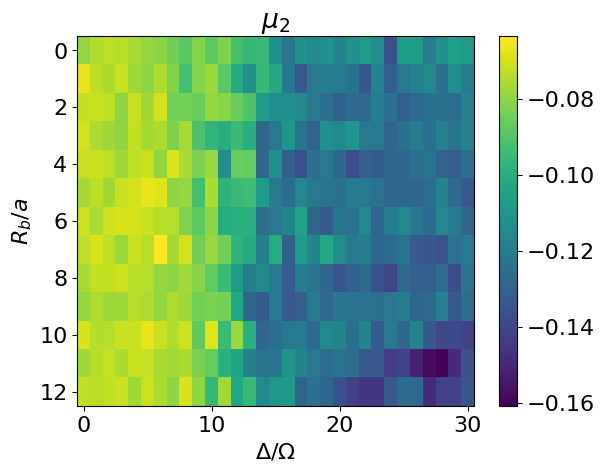

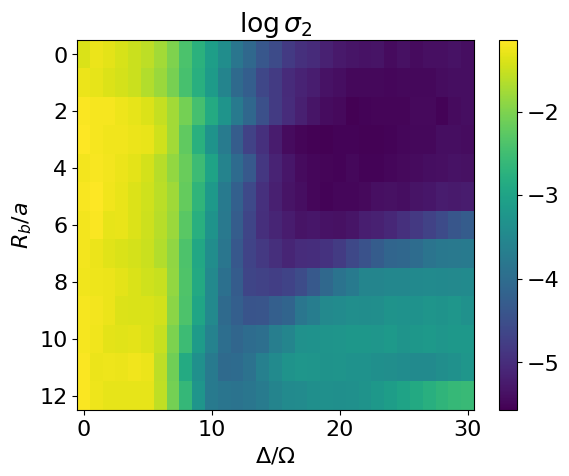

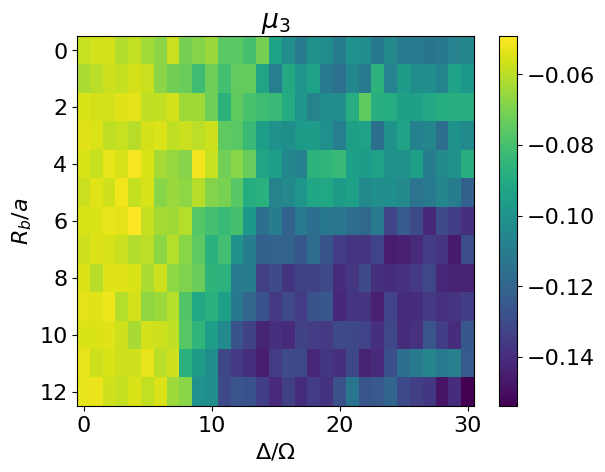

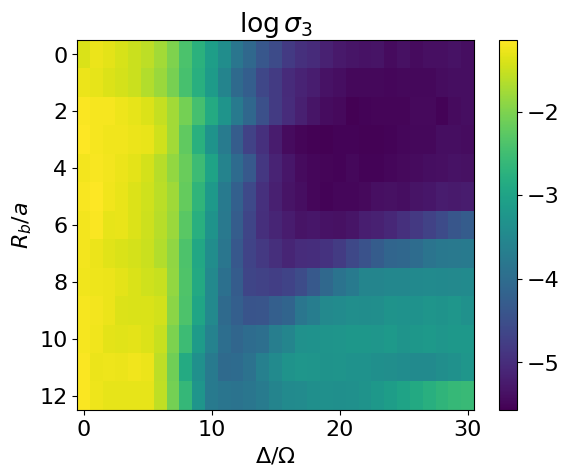

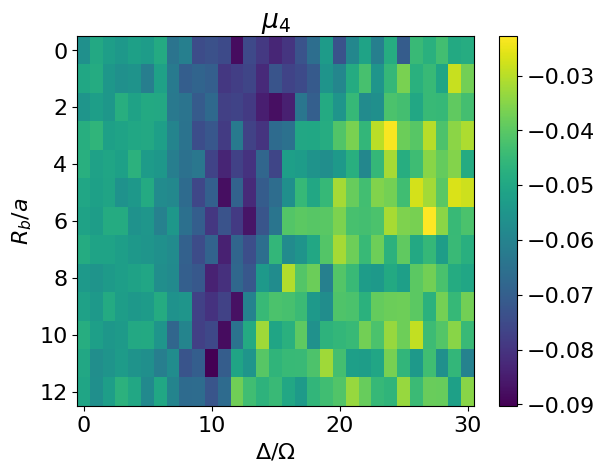

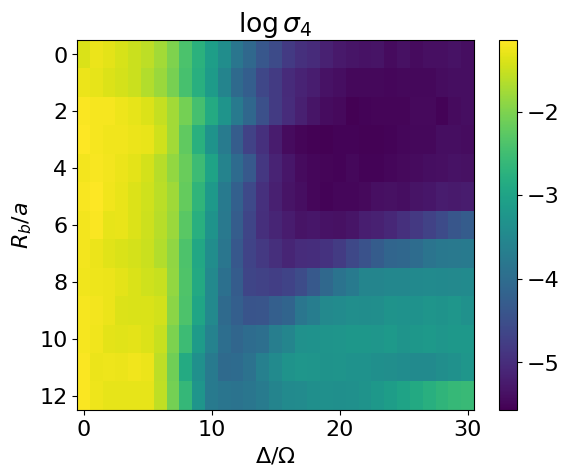

In [ ]:
d_model = 8
num_heads = d_model//2
key_init_d = jax.random.PRNGKey(34)
head_dim = d_model // num_heads
latent_dim = 5

key = jax.random.PRNGKey(1234)

for alpha in [0.001]:
  for gamma_min in [1.]:
    for gamma_max in [0.00]:
        for beta in [10]:

            gamma_max = gamma_min
            print('alpha: {},  beta: {},  gamma_max: {}, gamma_min: {}'.format(alpha,beta,gamma_max, gamma_min))
            #for m in range(10): #if want to average over many models


            m = 0

            ### INITIALIZATION ###

            #keys
            input_init = batches[0]
            rng = jax.random.PRNGKey(1234+m)
            key_init = jax.random.PRNGKey(124+m)
            key = jax.random.PRNGKey(12+m)


            #parameters of the VAE
            latent_dim =  5
            VAE = transformer_VAE(dropout = 0.1,
                        num_heads = num_heads,
                        d_model = d_model,
                        d_ff = 4*d_model,#4
                        num_layers = 3,#3
                        latent_dim = latent_dim)

            input_init = batches[0]
            params = VAE.init(jax.random.PRNGKey(0), input_init, key=key, train=False)
    
            #Optimizer
            lr = 0.001
            opt = optax.adabelief(learning_rate=lr)
            opt_state = opt.init(params)


            #Containers to store the values of the losses during the training
            history_loss = []
            history_loss_KL = []
            history_loss_RC = []
            history_logvar = []


            num_epochs = 50



            ### TRAINING ###

            for i in range(num_epochs):
              for j, batch in enumerate(batches):

                key = jax.random.split(key)[0]
                tot_num_epochs = num_epochs
                gamma = lin_annealing(i*40+j, 40*tot_num_epochs, gamma_min, gamma_max)

                val, grad = val_grad_fn(params, batch, alpha, beta, gamma, key)
                updates, opt_state = opt.update(grad, opt_state, params)
                params = optax.apply_updates(params, updates)

                if j%10==0:
                      history_loss.append(val.tolist())
                      KL = KL_loss(params, batch, key).tolist()
                      history_loss_KL.append(KL)
                      RC = RC_loss(params, batch, key).tolist()
                      history_loss_RC.append(RC)


                      mean, logvar, z, p = VAE.apply(params, batch, key=key, train=False)
                      history_logvar.append(logvar)


                if i%2==0 and j==0:
                      print("step: {}, loss: {}, KL: {}, RC: {}".format(i,val,KL,RC))
                      print("logvar: {}".format(jnp.mean(logvar, axis=0)))





            history_logvar = jnp.array(history_logvar)

            plt.rcParams['font.size'] = 16
            plt.figure(figsize=(7,5),dpi=100)

            plt.semilogy(history_loss_RC,color=sns.color_palette('Paired')[1], label="MSE")

            plt.legend()
            plt.xlabel('epochs')
            plt.ylabel(r'$\beta$VAE loss')
            plt.title(r'$\beta$={}, gamma_max={}, gamma_min={}'.format(beta,gamma_max, gamma_min))
            plt.show()

            plt.rcParams['font.size'] = 16
            plt.figure(figsize=(7,5),dpi=100)

            plt.plot([jnp.mean(history_logvar[i], axis=0) for i in range(len(history_logvar))])
            plt.xlabel('epochs')
            plt.ylabel(r'$\log(\sigma)$')
            plt.title(r'$\beta$={}, gamma_max={}, gamma_min={}'.format(beta,gamma_max, gamma_min))
            plt.show()


            plot_latents(params)



            data = {'params': params, 'history_loss': history_loss, 'history_loss_KL': history_loss_KL, 'history_loss_RC': history_loss_RC, 'alpha_beta_gamma':[alpha, beta, gamma], 'history_logvar': history_logvar}
            with open('RadbergExpL{}_data_model_Transf_beta{}_gammamax{}_ gamma_min{}_alpha{}.pkl'.format(L,beta,gamma_max, gamma_min, alpha), 'wb') as f:
                pickle.dump(data, f)



#### Results

##### latent space

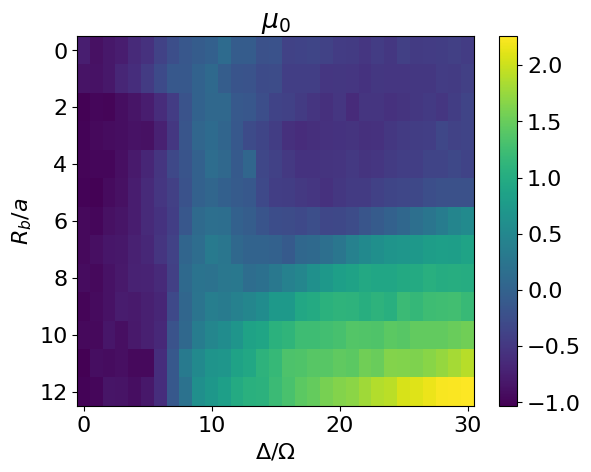

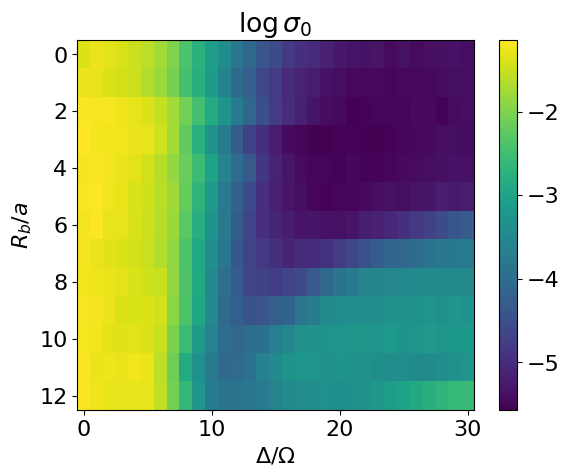

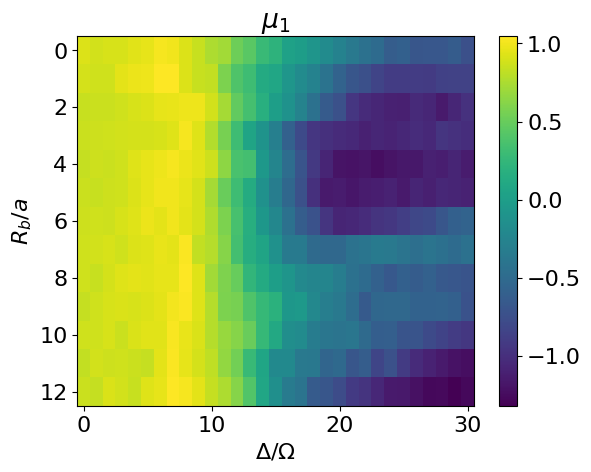

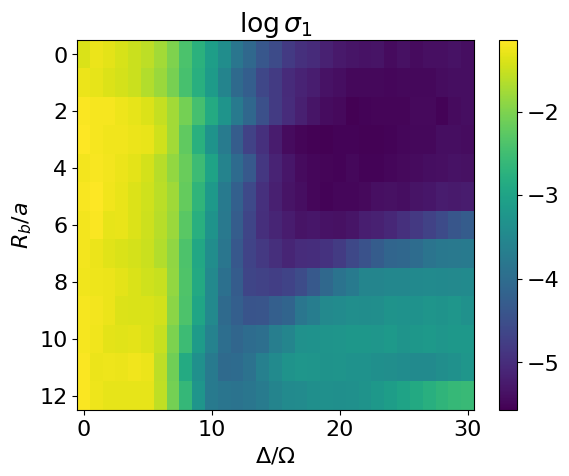

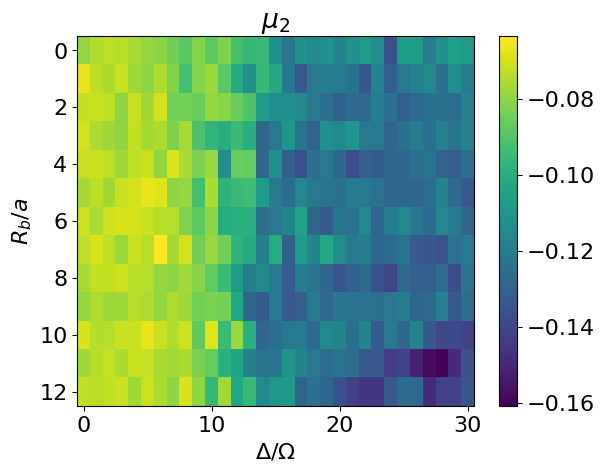

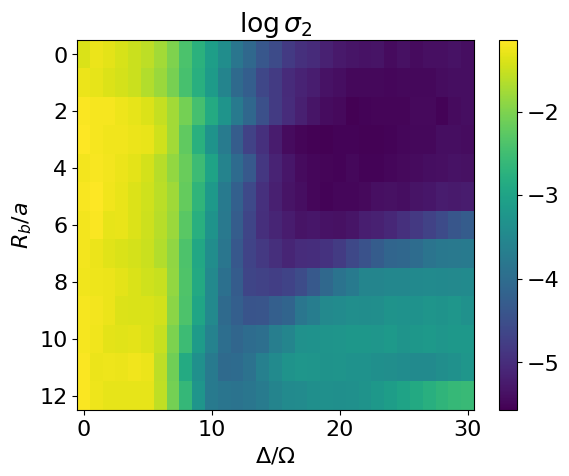

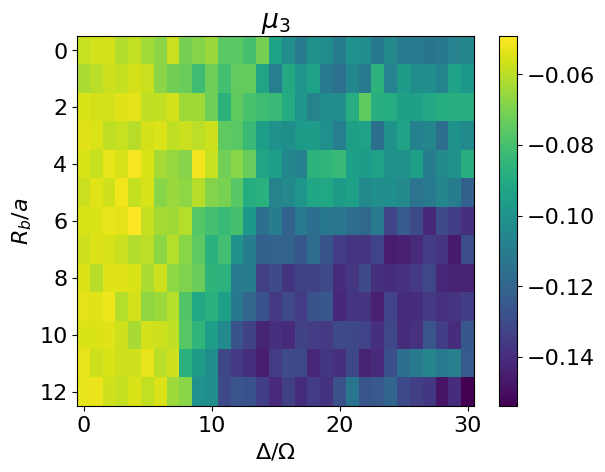

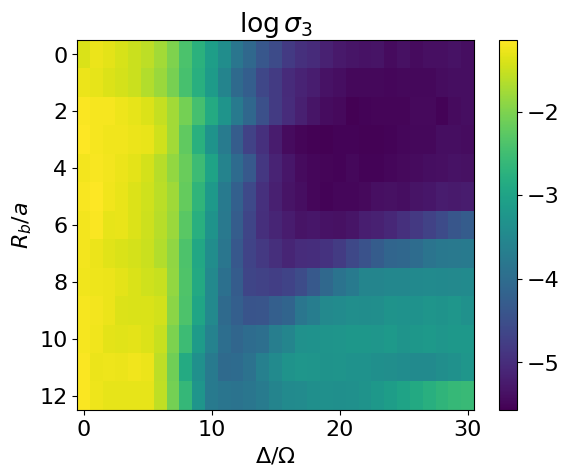

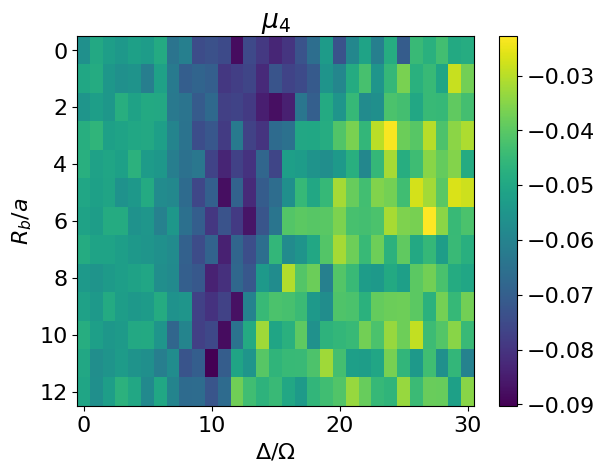

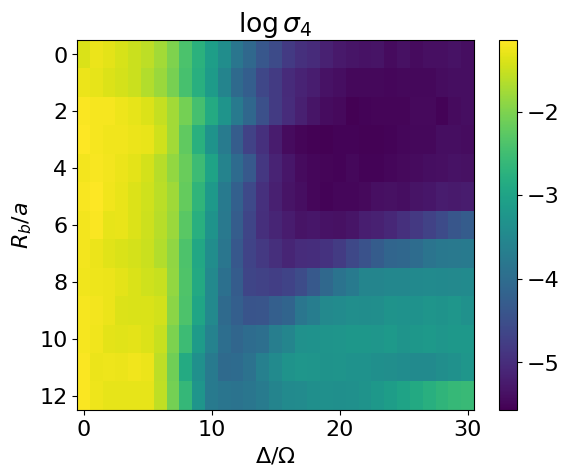

In [ ]:
plot_latents(params)

In [ ]:
params = data['params']
latent_dim = 5
all_mean = jnp.zeros((len(all_Rb),len(all_delta),latent_dim))
all_mean_abs = jnp.zeros((len(all_Rb),len(all_delta),latent_dim))
all_logvar = jnp.zeros((len(all_Rb),len(all_delta),latent_dim))
all_all_mean = jnp.zeros((len(all_Rb),len(all_delta),jnp.shape(dataset)[2],latent_dim))

d_model = 8
num_heads = d_model//2
key_init_d = jax.random.PRNGKey(34)
head_dim = d_model // num_heads
latent_dim = 5


VAE = transformer_VAE(dropout = 0.1,
                        num_heads = num_heads,
                        d_model = d_model,
                        d_ff = 4*d_model,#4
                        num_layers = 3,#3
                        latent_dim = latent_dim)

get_latent_var = jax.jit(partial(VAE.apply, train=False))


for i, Rb in enumerate(all_Rb):
    for j, delta in enumerate(all_delta):

        d = dataset[i,j]
        means, logvar, z, _  = get_latent_var(params, d, key)

        all_mean = all_mean.at[i,j].set(jnp.mean(means,axis=0))
        all_all_mean = all_all_mean.at[i,j].set(means)
        all_logvar = all_logvar.at[i,j].set(jnp.mean(logvar,axis=0))


idx = jnp.argsort(jnp.mean(all_logvar, axis=(0,1)))

latvar = {'mu0': all_all_mean[:,:,:,idx[0]], 'mu1': all_all_mean[:,:,:,idx[1]], 'logvar0': all_logvar[:,:,idx[0]], 'logvar1': all_logvar[:,:,idx[1]]}

with open('RydbergExpL13_latentvar.pkl', 'wb') as f:
  pickle.dump(latvar, f)